In [78]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, plot_confusion_matrix, plot_roc_curve, roc_curve 

# !pip3 install seaborn
# import seabron as sns
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Data "PreProcessing"

In [10]:
# Get the image file directories
train_dir = os.path.join('/Users/luctheduke/Desktop/UVM Grad School/Year 2/STAT 287 - DS 1/chest_xray/train')
test_dir = os.path.join('/Users/luctheduke/Desktop/UVM Grad School/Year 2/STAT 287 - DS 1/chest_xray/test')
validation_dir = os.path.join('/Users/luctheduke/Desktop/UVM Grad School/Year 2/STAT 287 - DS 1/chest_xray/val')

train_names_normal = os.listdir(os.path.join(train_dir,'NORMAL'))
train_names_pneumonia = os.listdir(os.path.join(train_dir,'PNEUMONIA'))

test_names_normal = os.listdir(os.path.join(test_dir,'NORMAL'))
test_names_pneumonia = os.listdir(os.path.join(test_dir,'PNEUMONIA'))

val_names_normal = os.listdir(os.path.join(validation_dir,'NORMAL'))
val_names_pneumonia = os.listdir(os.path.join(validation_dir,'PNEUMONIA'))

In [11]:
# Create datasets for training, testing, and validation
IMAGE_SIZE = (300, 300)

train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir, 
                                                                 image_size=IMAGE_SIZE,
                                                                 label_mode='binary', 
                                                                 batch_size=64,
                                                                )

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMAGE_SIZE,
                                                                batch_size=64,
                                                                label_mode="binary",shuffle=False)


val_data = tf.keras.preprocessing.image_dataset_from_directory(directory=validation_dir,
                                                                image_size=IMAGE_SIZE,
                                                                batch_size=64,
                                                                label_mode="binary", shuffle=False)

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


In [12]:
train_data?

Type:           BatchDataset
String form:    <BatchDataset shapes: ((None, 300, 300, 3), (None, 1)), types: (tf.float32, tf.float32)>
Length:         82
File:           /opt/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py
Docstring:      A `Dataset` that batches contiguous elements from its input.
Init docstring: See `Dataset.batch()` for details.


# EDA
- visualize number breakdown of classes in each of the train, test, and validation sets (see if we have a relatively balanced training set)
- visualize samples of Pneumonia and Normal images

In [13]:
labels = ['NORMAL', 'PNEUMONIA']
train_counts = {}

for l in labels:
    # train counts
    path = os.path.join(train_dir,l)
    fileList=os.listdir(path)
    train_counts[l] = len(fileList)

train_counts

{'NORMAL': 1341, 'PNEUMONIA': 3875}

In [14]:
class_weights = {}
class_weights[0] = train_counts['NORMAL']
class_weights[1] = train_counts['PNEUMONIA']

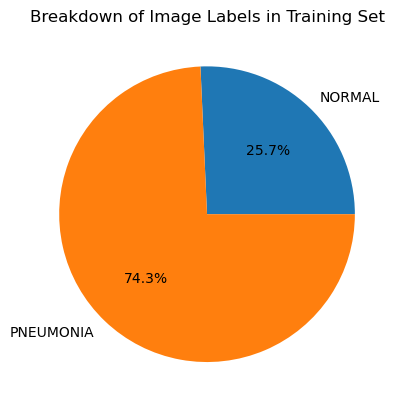

In [15]:
plt.title("Breakdown of Image Labels in Training Set")
plt.pie(list(train_counts.values()), labels=list(train_counts.keys()), autopct='%1.1f%%')
plt.savefig('/Users/luctheduke/Desktop/UVM Grad School/Year 2/STAT 287 - DS 1/stat287_project/images/' + 'pie.png')

The training data is not a balanced set - almost three times as many of the images are labeled to have pneumonia vs normal; this imbalance in the dataset could be problematic for our model.

Consider duplicating Normal dataset 3x to give close to a balanced dataset; consider data augmentation [stretching / rotating / zooming in & out depending on how standard format the images are]

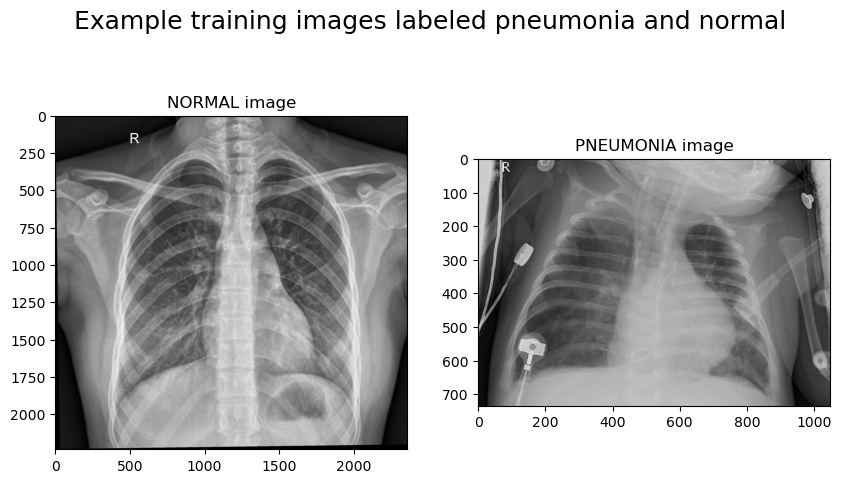

In [16]:
# Plotting code here: representative training images with pneumonia and normal
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
plt.suptitle("Example training images labeled pneumonia and normal", fontsize=18, y=0.95)

for l, ax in zip(labels, axs.ravel()):
    path = os.path.join(train_dir,l)
    for img in os.listdir(path):
        img_arr = Image.open(os.path.join(path,img)) 
        arr = np.array(img_arr)
        ax.set_title(f"{l} image")
        ax.imshow(np.array(img_arr), cmap='gray')
        break

In [17]:
# Preprocess the data
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.prefetch(buffer_size=AUTOTUNE)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)
val_data = val_data.prefetch(buffer_size=AUTOTUNE)

# 2. Model Building

In [18]:
# Construct the Model - 4 Conv layers w 2x2 Max Pooling layers after each

model = models.Sequential()

model.add(layers.Conv2D(16, (3, 3), activation='relu',
    input_shape=(300, 300, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        3

In [19]:
# Compiling the model
model.compile(loss='binary_crossentropy',
             optimizer=tf.keras.optimizers.Adam(),
             metrics=["acc", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),
                       tf.keras.metrics.SpecificityAtSensitivity(0.5), tf.keras.metrics.SensitivityAtSpecificity(0.5)])

In [20]:
# Fit the model
history = model.fit(train_data,
                   epochs=15,
                   steps_per_epoch=len(train_data),
                   validation_data=val_data,
                   validation_steps=len(val_data),
                   verbose=0,
                   class_weight=class_weights
                   )

2023-05-03 19:27:17.588514: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


# 3. Model Evaluation

[0.625, 0.875, 0.875, 0.9375, 1.0, 0.75, 1.0, 0.875, 1.0, 0.8125, 0.9375, 1.0, 0.8125, 1.0, 1.0]


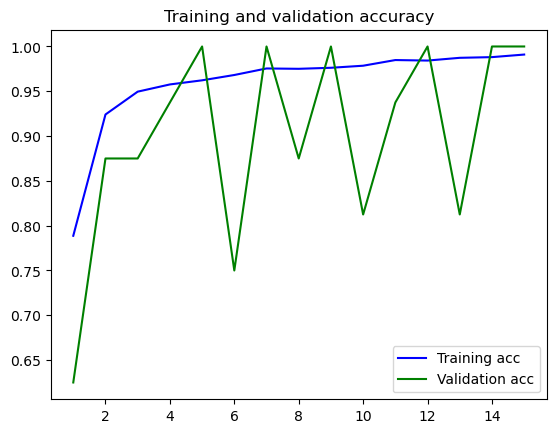

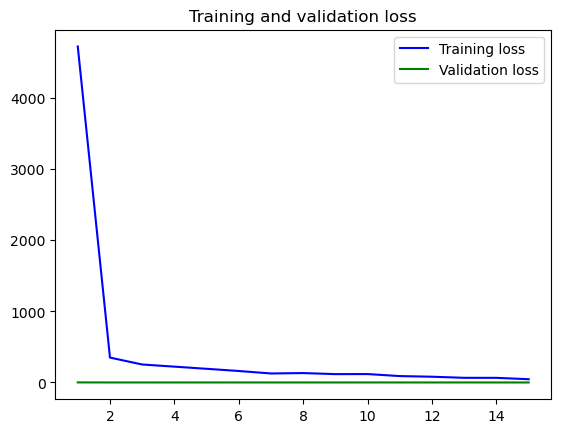

In [24]:
acc = history.history['acc']
val_acc = history.history['val_acc']
print(val_acc)
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'green', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'green', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [25]:
all_metrics = model.evaluate(test_data, steps=10, batch_size=32)

print(all_metrics)

10/10 [==============================] - 9s 699ms/step - loss: 2.5404 - acc: 0.7115 - precision_1: 0.6855 - recall_1: 0.9949 - specificity_at_sensitivity_1: 0.5043 - sensitivity_at_specificity_1: 0.9744
[2.5404105186462402, 0.7115384340286255, 0.685512363910675, 0.9948717951774597, 0.504273533821106, 0.9743589758872986]


In [30]:
predictions = (model.predict(test_data) > 0.5).astype("int32")

In [48]:
y_true = np.concatenate([y for x, y in test_data], axis=0)

In [50]:
print(classification_report(y_true, predictions))

              precision    recall  f1-score   support

         0.0       0.97      0.24      0.38       234
         1.0       0.69      0.99      0.81       390

    accuracy                           0.71       624
   macro avg       0.83      0.62      0.60       624
weighted avg       0.79      0.71      0.65       624



In [51]:
x_test = np.concatenate([x for x, y in test_data], axis=0)

In [83]:
# Plot confusion matrix - on training data
y_train = np.concatenate([x for x, y in train_data], axis=0)
train_pred = (model.predict(train_data) > 0.5).astype("int32")

res = tf.math.confusion_matrix(y_train.flatten(), train_pred.flatten())
res

InvalidArgumentError: Shapes of all inputs must match: values[0].shape = [1408320000] != values[1].shape = [5216] [Op:Pack] name: stack

In [68]:
# Plot confusion matrix
res = tf.math.confusion_matrix(y_true.flatten(), predictions.flatten())
res

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[ 56, 178],
       [  2, 388]], dtype=int32)>

In [66]:
import seaborn as sns

<AxesSubplot:>

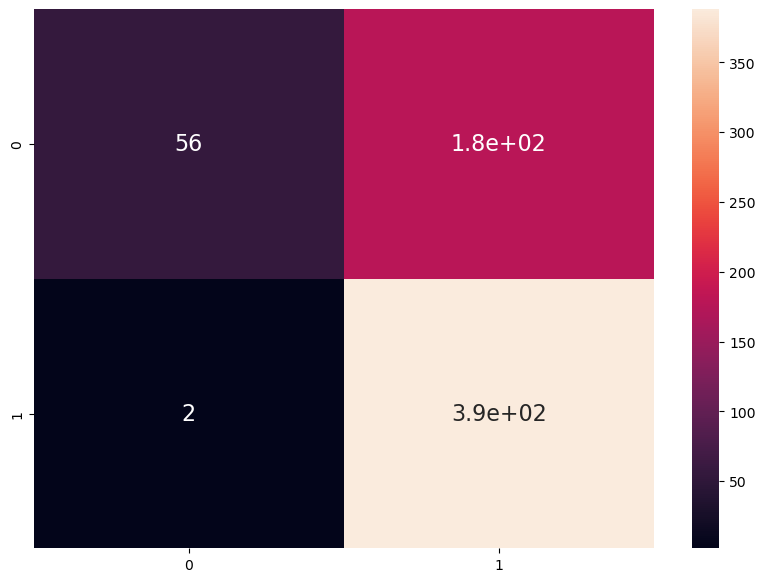

In [76]:
df_cm = pd.DataFrame(res)

plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16})

In [82]:
fpr, tpr = roc_curve(y_true, model.predict(test_data))

ValueError: too many values to unpack (expected 2)

In [ ]:
# Plot ROC Curve



# 3.2 Updated Model 
- Oversampling to account for imbalanced training set
- Sklearn's classweights

- build ROC curve, confusion matrix, and model eval vizzes on Test set

In [23]:
# Compiling the model
model.compile(loss='binary_crossentropy',
             optimizer=tf.keras.optimizers.Adam(),
             metrics=["acc", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),
                       tf.keras.metrics.SpecificityAtSensitivity(0.5), tf.keras.metrics.SensitivityAtSpecificity(0.5)])
# Fit the model
history = model.fit(train_data,
                   epochs=15,
                   steps_per_epoch=len(train_data),
                   validation_data=val_data,
                   validation_steps=len(val_data),
                   #TODO: might need to fix this so it's binary instead
                   class_weight = train_counts,
                   verbose=0)

ValueError: Expected `class_weight` to be a dict with keys from 0 to one less than the number of classes, found {'NORMAL': 1341, 'PNEUMONIA': 3875}

# 4. Model Interpretation - LIME (Local Interpretable Model-Agnostic Explanations)

resources:
1. https://homes.cs.washington.edu/~marcotcr/blog/lime/
2. https://medium.datadriveninvestor.com/xai-with-lime-for-cnn-models-5560a486578
3. https://stackoverflow.com/questions/62436302/extract-target-from-tensorflow-prefetchdataset#_=_

In [16]:
# !pip3 install lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import random

In [26]:
training_sample = [(example.numpy(), label.numpy()) for example, label in train_data][10]

(array([[[[3.33507767e+01, 3.33507767e+01, 3.33507767e+01],
          [3.36556664e+01, 3.36556664e+01, 3.36556664e+01],
          [3.51138878e+01, 3.51138878e+01, 3.51138878e+01],
          ...,
          [4.44533348e+01, 4.44533348e+01, 4.44533348e+01],
          [3.78499756e+01, 3.78499756e+01, 3.78499756e+01],
          [3.44792175e+01, 3.44792175e+01, 3.44792175e+01]],
 
         [[3.21800003e+01, 3.21800003e+01, 3.21800003e+01],
          [3.23300018e+01, 3.23300018e+01, 3.23300018e+01],
          [3.51049995e+01, 3.51049995e+01, 3.51049995e+01],
          ...,
          [4.70698776e+01, 4.70698776e+01, 4.70698776e+01],
          [3.80299759e+01, 3.80299759e+01, 3.80299759e+01],
          [3.32833252e+01, 3.32833252e+01, 3.32833252e+01]],
 
         [[3.23666687e+01, 3.23666687e+01, 3.23666687e+01],
          [3.25166702e+01, 3.25166702e+01, 3.25166702e+01],
          [3.55833359e+01, 3.55833359e+01, 3.55833359e+01],
          ...,
          [4.52498779e+01, 4.52498779e+01, 4.5249

In [27]:
training_sample

(array([[[[3.33507767e+01, 3.33507767e+01, 3.33507767e+01],
          [3.36556664e+01, 3.36556664e+01, 3.36556664e+01],
          [3.51138878e+01, 3.51138878e+01, 3.51138878e+01],
          ...,
          [4.44533348e+01, 4.44533348e+01, 4.44533348e+01],
          [3.78499756e+01, 3.78499756e+01, 3.78499756e+01],
          [3.44792175e+01, 3.44792175e+01, 3.44792175e+01]],
 
         [[3.21800003e+01, 3.21800003e+01, 3.21800003e+01],
          [3.23300018e+01, 3.23300018e+01, 3.23300018e+01],
          [3.51049995e+01, 3.51049995e+01, 3.51049995e+01],
          ...,
          [4.70698776e+01, 4.70698776e+01, 4.70698776e+01],
          [3.80299759e+01, 3.80299759e+01, 3.80299759e+01],
          [3.32833252e+01, 3.32833252e+01, 3.32833252e+01]],
 
         [[3.23666687e+01, 3.23666687e+01, 3.23666687e+01],
          [3.25166702e+01, 3.25166702e+01, 3.25166702e+01],
          [3.55833359e+01, 3.55833359e+01, 3.55833359e+01],
          ...,
          [4.52498779e+01, 4.52498779e+01, 4.5249

In [25]:
explainer = lime_image.LimeImageExplainer(random_state=42)
explanation = explainer.explain_instance(
         training_sample, 
         model.predict
)
plt.imshow(training_sample)

image, mask = explanation.get_image_and_mask(
         model.predict(
              training_sample.reshape((1,28,28,3))
         ).argmax(axis=1)[0],
         positive_only=True, 
         hide_rest=False)
plt.imshow(mark_boundaries(image, mask))

AttributeError: 'tuple' object has no attribute 'shape'